In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import clear_output

arr = np.array

In [33]:
%matplotlib inline

class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.valuation = np.random.uniform(.25,.75)
        self.bid_history = np.zeros(model.num_steps+1)
        self.wins = 0
        self.utility_history = np.zeros(model.num_steps+1)
        self.utility = 0
        self.ϵ = .01
        self.trial = False

    def submit_bid(self):
        e = np.random.uniform(0,1)
        if e>self.ϵ:
            self.bid = self.bid_history[self.utility_history.argmax()]
            self.trial = False
        else:
            self.bid = np.random.uniform()
            self.trial = True
        if self.bid == 0:
            self.bid = np.random.uniform()
            self.trial = True
        return self.bid
        
    def step(self):
        self.price = 0
        if self.unique_id == mod.winner:
#             self.price = self.bid # first-price auction
            self.price = mod.second # second-price auction
            self.utility = self.valuation - self.price
            self.utility_history[mod.round_cnt] = self.utility
            self.bid_history[mod.round_cnt] = self.bid
            self.wins += 1
    
    def advance(self):
#         print('advancing')
        pass
        
class MoneyModel(Model):
    def __init__(self, N, num_steps=50, verbose=False):
        self.verbose = verbose
        self.num_agents = N
        self.schedule = SimultaneousActivation(self)
        self.round_cnt = 0
        self.revenue = 0
        self.num_steps = num_steps
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
        self.datacollector = DataCollector(model_reporters={'Revenue': 'revenue', 'Max_bid':'max_bid'},
                                            agent_reporters={'Utility':'utility', 
                                                             'Bid':'bid', 
                                                             'Wins':'wins', 
                                                             'Valuation':'valuation',
                                                             'Trial':'trial',
                                                             'Price':'price'})
            
    def step(self):
        bids = arr([a.submit_bid() for a in self.schedule.agents]).round(3)
        self.winner = bids.argmax()
        self.max_bid = bids.max()
        
        self.second = np.where(bids==bids.max(), 0, bids).max()
        
        self.revenue += self.max_bid
        
        self.round_cnt += 1 
#         self.datacollector.collect(self)
        self.schedule.step()
        self.datacollector.collect(self)
        
        if self.verbose:
            clear_output()
            print('ROUND:', self.round_cnt, '\n', '='*20)
            print('bids:', bids)
            print('winner:', self.winner)
            print('win counter: ', [a.wins for a in self.schedule.agents])

# np.random.seed(1)
num_agents = 100
num_steps = 10000

mod = MoneyModel(num_agents, num_steps=num_steps, verbose=False)

for i in range(num_steps):
    mod.step()

valuations = arr([a.valuation for a in mod.schedule.agents])
print('Valuations: ', valuations.round(3))
print('win counter: ', [a.wins for a in mod.schedule.agents])

Valuations:  [0.654 0.468 0.449 0.405 0.301 0.592 0.46  0.56  0.386 0.274 0.598 0.299
 0.501 0.283 0.554 0.342 0.718 0.302 0.281 0.58  0.317 0.667 0.303 0.304
 0.479 0.541 0.398 0.534 0.384 0.487 0.422 0.523 0.697 0.596 0.589 0.472
 0.461 0.472 0.633 0.704 0.479 0.425 0.373 0.418 0.541 0.71  0.678 0.657
 0.627 0.678 0.279 0.46  0.346 0.662 0.472 0.693 0.486 0.324 0.701 0.301
 0.568 0.302 0.406 0.669 0.449 0.566 0.731 0.566 0.266 0.701 0.41  0.301
 0.447 0.47  0.26  0.613 0.365 0.252 0.607 0.318 0.73  0.517 0.733 0.277
 0.563 0.539 0.362 0.658 0.594 0.3   0.295 0.5   0.592 0.611 0.442 0.55
 0.736 0.37  0.669 0.277]
win counter:  [104, 103, 109, 114, 127, 105, 123, 103, 114, 73, 101, 96, 107, 119, 100, 108, 114, 109, 79, 99, 105, 109, 111, 114, 92, 87, 91, 104, 112, 98, 101, 95, 98, 93, 100, 98, 103, 96, 111, 94, 97, 116, 88, 117, 116, 108, 99, 104, 118, 108, 97, 87, 96, 98, 106, 95, 98, 95, 90, 102, 104, 100, 101, 92, 98, 98, 107, 95, 112, 110, 101, 103, 93, 82, 90, 91, 106, 80, 98, 95,

## Agent variables

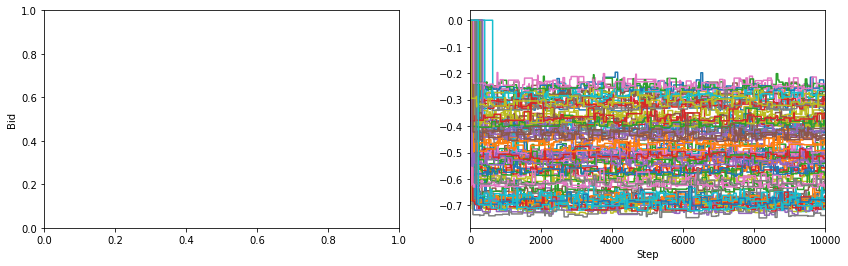

In [34]:
df = mod.datacollector.get_agent_vars_dataframe()
bids_df = df.reset_index().pivot(index='Step', columns='AgentID', values='Bid')
utils_df = df.reset_index().pivot(index='Step', columns='AgentID', values='Utility')
# df.head(20)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
# bids_df.plot(ax=ax1, legend=False)
ax1.set_ylabel('Bid')
# for a, c in zip(mod.schedule.agents, ['blue', 'orange']):
#     ax1.axhline(a.valuation, color=c)
    
utils_df.plot(ax=ax2, legend=False)
    
plt.show()

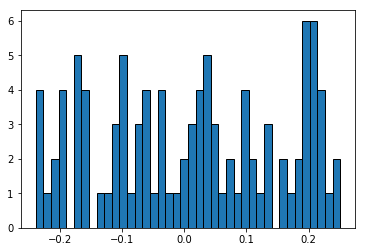

In [37]:
# utils_df
# bids_df.iloc[-1]-valuations
# sns.distplot(bids_df.mean()-valuations)
plt.hist(bids_df.mean()-valuations, edgecolor='k', bins=40)
plt.show()

In [32]:
# bids_df.head(30)
# bids_df.iloc[-1]-valuations
print(df.head(20))
print(df.tail(20))

               Utility       Bid  Wins  Valuation  Trial  Price
Step AgentID                                                   
1    0        0.000000  0.161990     0   0.254715   True  0.000
     1        0.000000  0.833321     0   0.305734   True  0.000
     2        0.000000  0.494748     0   0.637186   True  0.000
     3        0.000000  0.388014     0   0.541210   True  0.000
     4        0.000000  0.809513     0   0.536471   True  0.000
     5        0.000000  0.020738     0   0.488192   True  0.000
     6        0.000000  0.217532     0   0.299023   True  0.000
     7        0.000000  0.533274     0   0.658078   True  0.000
     8        0.000000  0.860926     0   0.315166   True  0.000
     9        0.000000  0.008383     0   0.668663   True  0.000
     10      -0.564448  0.993475     1   0.421552   True  0.986
     11       0.000000  0.641297     0   0.613759   True  0.000
     12       0.000000  0.269497     0   0.371015   True  0.000
     13       0.000000  0.401145     0  

## Model variables

In [39]:
df = mod.datacollector.get_model_vars_dataframe()
b,a = np.polyfit(x=df.index, y=df.Max_bid, deg=1)

df.head()
# df.Max_bid.plot()
# plt.plot(df.index, a+df.index*b)
# plt.legend()
# plt.show()

,Revenue,Max_bid
0,0.441,0.441
1,0.882,0.441
2,1.607,0.725
3,2.048,0.441
4,2.489,0.441
